# Working with Order Book Data: NASDAQ ITCH

The primary source of market data is the order book, which is continuously updated in real-time throughout the day to reflect all trading activity. Exchanges typically offer this data as a real-time service and may provide some historical data for free.

The trading activity is reflected in numerous messages about trade orders sent by market participants. These messages typically conform to the electronic Financial Information eXchange (FIX) communications protocol for real-time exchange of securities transactions and market data or a native exchange protocol. 

## Imports

In [1]:
import gzip
import shutil
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from struct import unpack
from collections import namedtuple, Counter
from datetime import timedelta
from time import time

### Set Data paths

We will store the download in a `data` subdirectory and convert the result to `hdf` format (discussed in the last section of chapter 2).

In [6]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'
date = '10302019'

## Build Order Book

In [7]:
stock = 'AAPL'
order_dict = {-1: 'sell', 1: 'buy'}

The parsed messages allow us to rebuild the order flow for the given day. The 'R' message type contains a listing of all stocks traded during a given day, including information about initial public offerings (IPOs) and trading restrictions.

Throughout the day, new orders are added, and orders that are executed and canceled are removed from the order book. The proper accounting for messages that reference orders placed on a prior date would require tracking the order book over multiple days, but we are ignoring this aspect here.

### Get all messages for given stock

The `get_messages()` function illustrates how to collect the orders for a single stock that affects trading (refer to the ITCH specification for details about each message):

In [8]:
def get_messages(date, stock=stock):
    """Collect trading messages for given stock"""
    with pd.HDFStore(itch_store) as store:
        stock_locate = store.select('R', where='stock = stock').stock_locate.iloc[0]
        target = 'stock_locate = stock_locate'

        data = {}
        # trading message types
        messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']
        for m in messages:
            data[m] = store.select(m, where=target).drop('stock_locate', axis=1).assign(type=m)

    order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
    orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]

    for m in messages[2: -3]:
        data[m] = data[m].merge(orders, how='left')

    data['U'] = data['U'].merge(orders, how='left',
                                right_on='order_reference_number',
                                left_on='original_order_reference_number',
                                suffixes=['', '_replaced'])

    data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
    data['X']['shares'] = data['X']['cancelled_shares']
    data['X'] = data['X'].dropna(subset=['price'])

    data = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)
    data['date'] = pd.to_datetime(date, format='%m%d%Y')
    data.timestamp = data['date'].add(data.timestamp)
    data = data[data.printable != 0]

    drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
                 'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
                 'printable', 'date', 'cancelled_shares']
    return data.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)


In [9]:
messages = get_messages(date=date)
messages.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813995 entries, 0 to 813994
Data columns (total 9 columns):
timestamp             813995 non-null datetime64[ns]
buy_sell_indicator    755909 non-null float64
shares                808719 non-null float64
price                 808719 non-null float64
type                  813995 non-null object
executed_shares       54582 non-null float64
execution_price       371 non-null float64
shares_replaced       4886 non-null float64
price_replaced        4886 non-null float64
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 55.9+ MB


In [10]:
with pd.HDFStore(order_book_store) as store:
    key = '{}/messages'.format(stock)
    store.put(key, messages)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/buy                 frame_table  (typ->appendable,nrows->37503256,ncols->2,indexers->[index],dc->[])
/AAPL/messages            frame        (shape->[813995,9])                                                
/AAPL/sell                frame_table  (typ->appendable,nrows->30746169,ncols->2,indexers->[index],dc->[])
/AAPL/trades              frame        (shape->[72015,3])                                                 


### Combine Trading Records

Reconstructing successful trades, that is, orders that are executed as opposed to those that were canceled from trade-related message types, C, E, P, and Q, is relatively straightforward:

In [11]:
def get_trades(m):
    """Combine C, E, P and Q messages into trading records"""
    trade_dict = {'executed_shares': 'shares', 'execution_price': 'price'}
    cols = ['timestamp', 'executed_shares']
    trades = pd.concat([m.loc[m.type == 'E', cols + ['price']].rename(columns=trade_dict),
                        m.loc[m.type == 'C', cols + ['execution_price']].rename(columns=trade_dict),
                        m.loc[m.type == 'P', ['timestamp', 'price', 'shares']],
                        m.loc[m.type == 'Q', ['timestamp', 'price', 'shares']].assign(cross=1),
                        ], sort=False).dropna(subset=['price']).fillna(0)
    return trades.set_index('timestamp').sort_index().astype(int)

In [12]:
trades = get_trades(messages)
print(trades.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72015 entries, 2019-10-30 04:00:02.486519868 to 2019-10-30 19:59:59.248635671
Data columns (total 3 columns):
shares    72015 non-null int64
price     72015 non-null int64
cross     72015 non-null int64
dtypes: int64(3)
memory usage: 2.2 MB
None


In [13]:
with pd.HDFStore(order_book_store) as store:
    store.put('{}/trades'.format(stock), trades)

### Create Orders

The order book keeps track of limit orders, and the various price levels for buy and sell orders constitute the depth of the order book. To reconstruct the order book for a given level of depth requires the following steps:


The `add_orders()` function accumulates sell orders in ascending, and buy orders in descending order for a given timestamp up to the desired level of depth:

In [14]:
def add_orders(orders, buysell, nlevels):
    """Add orders up to desired depth given by nlevels;
        sell in ascending, buy in descending order
    """
    new_order = []
    items = sorted(orders.copy().items())
    if buysell == 1:
        items = reversed(items)  
    for i, (p, s) in enumerate(items, 1):
        new_order.append((p, s))
        if i == nlevels:
            break
    return orders, new_order

In [15]:
def save_orders(orders, append=False):
    cols = ['price', 'shares']
    for buysell, book in orders.items():
        df = (pd.concat([pd.DataFrame(data=data,
                                     columns=cols)
                         .assign(timestamp=t) 
                         for t, data in book.items()]))
        key = '{}/{}'.format(stock, order_dict[buysell])
        df.loc[:, ['price', 'shares']] = df.loc[:, ['price', 'shares']].astype(int)
        with pd.HDFStore(order_book_store) as store:
            if append:
                store.append(key, df.set_index('timestamp'), format='t')
            else:
                store.put(key, df.set_index('timestamp'))

We iterate over all ITCH messages and process orders and their replacements as required by the specification (this can take a while):

In [16]:
order_book = {-1: {}, 1: {}}
current_orders = {-1: Counter(), 1: Counter()}
message_counter = Counter()
nlevels = 100

start = time()
for message in messages.itertuples():
    i = message[0]
    if i % 1e5 == 0 and i > 0:
        print('{:,.0f}\t\t{}'.format(i, timedelta(seconds=time() - start)))
        save_orders(order_book, append=True)
        order_book = {-1: {}, 1: {}}
        start = time()
    if np.isnan(message.buy_sell_indicator):
        continue
    message_counter.update(message.type)

    buysell = message.buy_sell_indicator
    price, shares = None, None

    if message.type in ['A', 'F', 'U']:
        price = int(message.price)
        shares = int(message.shares)

        current_orders[buysell].update({price: shares})
        current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
        order_book[buysell][message.timestamp] = new_order

    if message.type in ['E', 'C', 'X', 'D', 'U']:
        if message.type == 'U':
            if not np.isnan(message.shares_replaced):
                price = int(message.price_replaced)
                shares = -int(message.shares_replaced)
        else:
            if not np.isnan(message.price):
                price = int(message.price)
                shares = -int(message.shares)

        if price is not None:
            current_orders[buysell].update({price: shares})
            if current_orders[buysell][price] <= 0:
                current_orders[buysell].pop(price)
            current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
            order_book[buysell][message.timestamp] = new_order

100,000		0:00:41.588766
200,000		0:00:57.306621
300,000		0:00:59.233570
400,000		0:00:58.586712
500,000		0:01:02.755569
600,000		0:01:02.367195
700,000		0:01:03.852932
800,000		0:00:51.740937


In [17]:
message_counter = pd.Series(message_counter)
print(message_counter)

A    357225
E     52781
D    318295
P     18861
X       576
F      2928
U      4886
C       357
dtype: int64


In [18]:
with pd.HDFStore(order_book_store) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/buy                 frame_table  (typ->appendable,nrows->75006512,ncols->2,indexers->[index],dc->[])
/AAPL/messages            frame        (shape->[813995,9])                                                
/AAPL/sell                frame_table  (typ->appendable,nrows->61492338,ncols->2,indexers->[index],dc->[])
/AAPL/trades              frame        (shape->[72015,3])                                                 


## Order Book Depth

In [19]:
with pd.HDFStore(order_book_store) as store:
    buy = store['{}/buy'.format(stock)].reset_index().drop_duplicates()
    sell = store['{}/sell'.format(stock)].reset_index().drop_duplicates()

### Price to Decimals

In [20]:
buy.price = buy.price.mul(1e-4)
sell.price = sell.price.mul(1e-4)

### Remove outliers

In [21]:
percentiles = [.01, .02, .1, .25, .75, .9, .98, .99]
pd.concat([buy.price.describe(percentiles=percentiles).to_frame('buy'),
           sell.price.describe(percentiles=percentiles).to_frame('sell')], axis=1)

,buy,sell
count,3.750326e+07,3.074617e+07
mean,2.436934e+02,2.496396e+02
std,2.001204e+00,1.137489e+03
min,1.000000e-02,2.412500e+02
1%,2.425800e+02,2.414600e+02
2%,2.427700e+02,2.416300e+02
10%,2.430600e+02,2.421100e+02
25%,2.432700e+02,2.425500e+02
50%,2.436000e+02,2.430200e+02
75%,2.440700e+02,2.435900e+02


In [22]:
buy = buy[buy.price > buy.price.quantile(.01)]
sell = sell[sell.price < sell.price.quantile(.99)]

### Buy-Sell Order Distribution

The number of orders at different price levels, highlighted in the following screenshot using different intensities for buy and sell orders, visualizes the depth of liquidity at any given point in time.

The distribution of limit order prices was weighted toward buy orders at higher prices.

In [23]:
market_open='0930'
market_close = '1600'

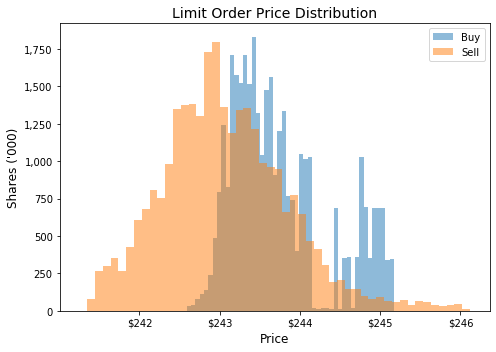

In [24]:
fig, ax = plt.subplots(figsize=(7,5))
hist_kws = {'linewidth': 1, 'alpha': .5}
sns.distplot(buy.set_index('timestamp').between_time(market_open, market_close).price, ax=ax, label='Buy', kde=False, hist_kws=hist_kws)
sns.distplot(sell.set_index('timestamp').between_time(market_open, market_close).price, ax=ax, label='Sell', kde=False, hist_kws=hist_kws)
plt.legend(fontsize=10)
plt.title('Limit Order Price Distribution', fontsize=14)
ax.set_yticklabels(['{:,}'.format(int(y/1000)) for y in ax.get_yticks().tolist()])
ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
plt.xlabel('Price', fontsize=12)
plt.ylabel('Shares (\'000)', fontsize=12)
plt.tight_layout()
# plt.savefig('figures/price_distribution', dpi=600);

### Order Book Depth

In [25]:
utc_offset = timedelta(hours=4)
depth = 100

In [26]:
buy_per_min = (buy
               .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
               .shares
               .sum()
               .apply(np.log)
               .to_frame('shares')
               .reset_index('price')
               .between_time(market_open, market_close)
               .groupby(level='timestamp', as_index=False, group_keys=False)
               .apply(lambda x: x.nlargest(columns='price', n=depth))
               .reset_index())
buy_per_min.timestamp = buy_per_min.timestamp.add(utc_offset).astype(int)
buy_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39100 entries, 0 to 39099
Data columns (total 3 columns):
timestamp    39100 non-null int64
price        39100 non-null float64
shares       39100 non-null float64
dtypes: float64(2), int64(1)
memory usage: 916.5 KB


In [27]:
sell_per_min = (sell
                .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
                .shares
                .sum()
                .apply(np.log)
                .to_frame('shares')
                .reset_index('price')
                .between_time(market_open, market_close)
                .groupby(level='timestamp', as_index=False, group_keys=False)
                .apply(lambda x: x.nsmallest(columns='price', n=depth))
                .reset_index())

sell_per_min.timestamp = sell_per_min.timestamp.add(utc_offset).astype(int)
sell_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39100 entries, 0 to 39099
Data columns (total 3 columns):
timestamp    39100 non-null int64
price        39100 non-null float64
shares       39100 non-null float64
dtypes: float64(2), int64(1)
memory usage: 916.5 KB


In [28]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]
trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0].between_time(market_open, market_close)

trades_per_min = (trades
                  .resample('Min')
                  .agg({'price': 'mean', 'shares': 'sum'}))
trades_per_min.index = trades_per_min.index.to_series().add(utc_offset).astype(int)
trades_per_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 1572442200000000000 to 1572465540000000000
Data columns (total 2 columns):
price     390 non-null float64
shares    390 non-null int64
dtypes: float64(1), int64(1)
memory usage: 9.1 KB


The following plots the evolution of limit orders and prices throughout the trading day: the dark line tracks the prices for executed trades during market hours, whereas the red and blue dots indicate individual limit orders on a per-minute basis (see notebook for details)

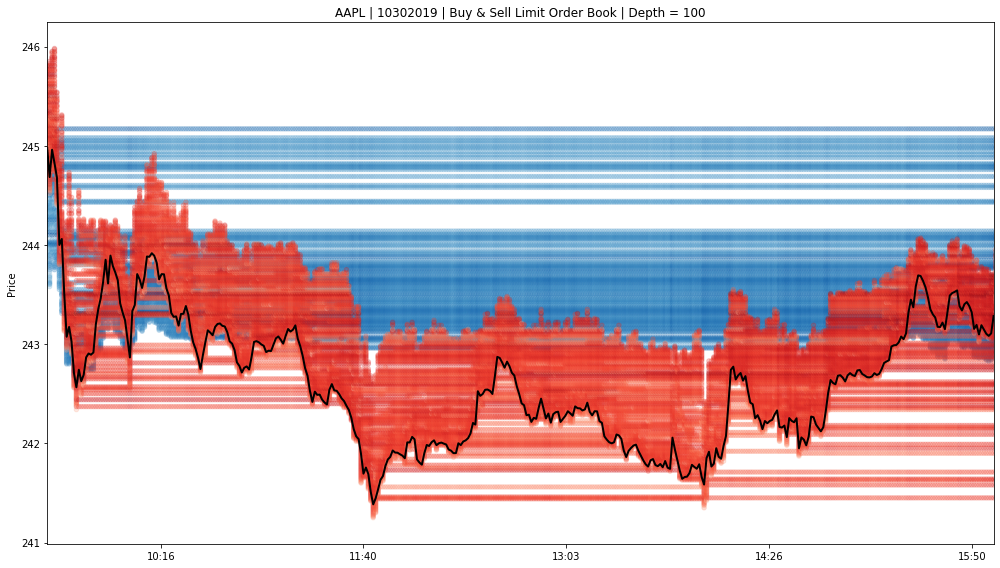

In [29]:
fig, ax = plt.subplots(figsize=(7, 5))

buy_per_min.plot.scatter(x='timestamp',y='price', c='shares', ax=ax, colormap='Blues', colorbar=False, alpha=.25)
sell_per_min.plot.scatter(x='timestamp',y='price', c='shares', ax=ax, colormap='Reds', colorbar=False, alpha=.25)
trades_per_min.price.plot(figsize=(14, 8), c='k', ax=ax, lw=2, 
                          title=f'AAPL | {date} | Buy & Sell Limit Order Book | Depth = {depth}')

xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
ax.set_xticklabels(xticks)

ax.set_xlabel('')
ax.set_ylabel('Price')

fig.tight_layout()
# fig.savefig('figures/order_book', dpi=600);